In [3]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import os
import glob

from datetime import date, datetime, timedelta, time

from sunpy.net import Fido
from sunpy.net import attrs as a
from sunpy.timeseries import TimeSeries



Steps
1. Choose event
2. Get GIC data and clean
3. Get MAG data and clean
4. Get solar wind and geo index data
5. Integrate based on datetime 
6. Output integrated data files for GIC and MAG separately


### Utility Functions

[10291, 10292, 10293, 10294, 10295, 10296, 10238]

In [17]:
def nerc_string_time_reader(df,columnLabel):
    '''
        df = dataframe with NERC data readings
        columnLabel = column label for the time strings  
    '''
    
    dt_list = [datetime.strptime(val, '%m/%d/%Y %I:%M:%S %p') for val in df[columnLabel].values]
    
    return dt_list


def nerc_gic_data_cleaning(dir_location, df_GIC):
    '''
        Returns a string with Device IDs that indicate bad stations to remove from the DF of GIC observations
    '''
    
    running_bad_station_list = []
    
    # Remove Stations with error quality reports
    for file in glob.glob(os.path.join(dir_location,'gic_monitor_missing_data*')):
        file_errors = file
#         file_errors = 'gic_monitor_missing_data_data_quality_reports_2015E06.csv'
    bad_gic_data = pd.read_csv(file_errors)
    print('bad gic stations for this event = \n{}'.format(list(set(bad_gic_data['Device ID'].values))))

    for l in list(set(bad_gic_data['Device ID'].values)):
        running_bad_station_list.append(str(l))
        
    # Remove Stations with low numbers of observations or whose observations are constant
    for c in df_GIC.columns.to_list():

        nan_mask = ~np.isnan(df_GIC[c])

        if df_GIC[c].count() < 2000.:
            running_bad_station_list.append(c)
        elif ( len(np.unique((df_GIC[c][nan_mask]))) < 10 ): # less than 10 unique data points
            print('station {} has < 10 unique data points'.format(c))
            running_bad_station_list.append(c)
        
    
    return running_bad_station_list


def nerc_gic_data_reshaping(df):
    '''
        df must have the following columns:
            GICDeviceID
            SampleDateTime
            GICMeasured
    '''
    list_times = nerc_string_time_reader(df,'SampleDateTime')
#     list_times
    
    df_times = pd.Series(list_times,name='datetimes')
    df_new = pd.concat([df,df_times],axis=1)
    df_new = df_new.set_index('datetimes')
    colName = str(df_new['GICDeviceID'].values[0])
    df_new = df_new.rename(columns={"GICMeasured": colName})
    df_new = df_new.drop(columns=['GICDeviceID','SampleDateTime'])

    
    return df_new

In [5]:

# Get the current working directory
cwd = os.getcwd()

# Print the current working directory
print("Current working directory: {0}".format(cwd))


Current working directory: /Users/ryanmc/Documents/Conferences/Jack_Eddy_Symposium_2022/dev/risk-resiliency-spwx


### Choose event and get files

In [6]:
event_no = 8


event_list = np.loadtxt('event_list.txt', str)

for i in range(len(event_list)):
    print('\t events list item {}:{}'.format(i,event_list[i]))

files_dir_gic = 'data/'+event_list[event_no,3]+'/GIC/'


print(files_dir_gic) 

	 events list item 0:['0' '2013-05-31T00:00' '2013-06-02T00:00' 'event_20130531']
	 events list item 1:['1' '2013-10-02T00:00' '2013-10-04T00:00' 'event_20131002']
	 events list item 2:['2' '2015-03-17T00:00' '2015-03-19T00:00' 'event_20150317']
	 events list item 3:['3' '2015-06-22T00:00' '2015-06-24T00:00' 'event_20150622']
	 events list item 4:['4' '2015-09-11T00:00' '2015-09-12T00:00' 'event_20150911']
	 events list item 5:['5' '2015-09-19T00:00' '2015-09-21T00:00' 'event_20150919']
	 events list item 6:['6' '2015-10-06T00:00' '2015-10-10T00:00' 'event_20151006']
	 events list item 7:['7' '2015-12-20T00:00' '2015-12-22T00:00' 'event_20151220']
	 events list item 8:['8' '2017-05-27T00:00' '2017-05-28T00:00' 'event_20170527']
	 events list item 9:['9' '2017-09-07T00:00' '2017-09-10T00:00' 'event_20170907']
	 events list item 10:['10' '2017-09-27T00:00' '2017-09-30T00:00' 'event_20170927']
	 events list item 11:['11' '2018-08-25T00:00' '2018-08-28T00:00' 'event_20180825']
	 events lis

### Get GIC data

In [41]:
# Create a dataframe of datetimes spanning the event and that will be used as the common index for all time series

format = '%Y-%m-%dT%H:%M'

event_start = datetime.strptime(event_list[event_no,1], format)
event_end = datetime.strptime(event_list[event_no,2], format) + timedelta(days=1)
df_event_dates = pd.date_range(event_start,event_end,freq='10s')

df_event_dates = df_event_dates.to_pydatetime()
df_event_dates = pd.DataFrame(df_event_dates,columns=['datetimes'])
# df_event_dates = df_event_dates.index.rename('Datetimes', inplace=True)
df_event_dates


,datetimes
0,2017-05-27 00:00:00
1,2017-05-27 00:00:10
2,2017-05-27 00:00:20
3,2017-05-27 00:00:30
4,2017-05-27 00:00:40
...,...
17276,2017-05-28 23:59:20
17277,2017-05-28 23:59:30
17278,2017-05-28 23:59:40
17279,2017-05-28 23:59:50


In [42]:
# loop over files in the directory for a given event and create merged DFs for GICs

df_GIC = df_event_dates

for f in glob.glob(os.path.join(files_dir_gic,'*csv')):#[0:10]:
    
    # Skip missing data files
    if ('missing' in f) | ('monitor' in f) | ('magnetometers' in f):
        print('-------> skipping file = {}'.format(f))
        continue
    print(f)
    
    # Read and reshape the data
    df_loop = pd.read_csv(f)
    
    df_loop = nerc_gic_data_reshaping(df_loop)
            
    # Merge into full dataframe
    df_GIC = pd.merge(df_GIC, df_loop, on='datetimes',how='left')

data/event_20170527/GIC/2017E01_10214.csv
data/event_20170527/GIC/2017E01_10348.csv
data/event_20170527/GIC/2017E01_10412.csv
data/event_20170527/GIC/2017E01_10406.csv
data/event_20170527/GIC/2017E01_10360.csv
data/event_20170527/GIC/2017E01_10189.csv
data/event_20170527/GIC/2017E01_10188.csv
data/event_20170527/GIC/2017E01_10407.csv
data/event_20170527/GIC/2017E01_10361.csv
data/event_20170527/GIC/2017E01_10413.csv
data/event_20170527/GIC/2017E01_10201.csv
data/event_20170527/GIC/2017E01_10229.csv
data/event_20170527/GIC/2017E01_10363.csv
data/event_20170527/GIC/2017E01_10405.csv
data/event_20170527/GIC/2017E01_10411.csv
data/event_20170527/GIC/2017E01_10377.csv
data/event_20170527/GIC/2017E01_10388.csv
data/event_20170527/GIC/2017E01_10410.csv
data/event_20170527/GIC/2017E01_10376.csv
data/event_20170527/GIC/2017E01_10362.csv
data/event_20170527/GIC/2017E01_10404.csv
data/event_20170527/GIC/2017E01_10202.csv
data/event_20170527/GIC/2017E01_10206.csv
data/event_20170527/GIC/2017E01_10

In [43]:
df_GIC

,datetimes,10214,10348,10412,10406,10360,10189,10188,10407,10361,10413,10201,10229,10363,10405,10411,10377,10388,10410,10376,10362,10404,10202,10206,10400,10414,10428,10399,10398,10401,10207,10213,10205,10239,10403,10198,10364,10402,10238,10204,10075,10263,10115,10114,10276,10262,10074,10076,10260,10300,10116,10117,10301,10261,10063,10077,10067,10098,10271,10259,10305,10107,10113,10112,10338,10258,10264,10066,10072,10064,10299,10306,10111,10273,10071,10083,10097,10295,10336,10322,10120,10121,10323,10294,10257,10094,10080,10296,10309,10321,10335,10320,10297,10254,10081,10293,10324,10318,10319,10331,10325,10292,10251,10079,10253,10290,10119,10440,10291,10252,10078,10433,10427,10341,10382,10194,10180,10181,10383,10397,10432,10220,10208,10236,10222,10342,10381,10183,10197,10196,10182,10380,10431,10343,10425,10237,10227,10421,10347,10435,10409,10384,10192,10193,10408,10434,10420,10346,10226,10232,10224,10230,10218,10436,10344,10378,10387,10191,10184,10190,10386,10345,10437,10231
0,2017-05-27 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-05-27 00:00:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-05-27 00:00:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-05-27 00:00:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-05-27 00:00:40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

### Apply filtering of GIC data


In [44]:
bad_stations = nerc_gic_data_cleaning(files_dir_gic, df_GIC)
print(bad_stations)


bad gic stations for this event = 
[10291, 10292, 10293, 10294, 10295, 10296, 10238]
station 10360 has < 10 unique data points
station 10361 has < 10 unique data points
station 10229 has < 10 unique data points
station 10206 has < 10 unique data points
station 10115 has < 10 unique data points
station 10112 has < 10 unique data points
station 10121 has < 10 unique data points
station 10309 has < 10 unique data points
station 10293 has < 10 unique data points
station 10324 has < 10 unique data points
station 10325 has < 10 unique data points
station 10292 has < 10 unique data points
station 10440 has < 10 unique data points
station 10343 has < 10 unique data points
station 10425 has < 10 unique data points
station 10421 has < 10 unique data points
station 10347 has < 10 unique data points
station 10408 has < 10 unique data points
station 10434 has < 10 unique data points
station 10346 has < 10 unique data points
station 10226 has < 10 unique data points
station 10230 has < 10 unique dat

In [45]:

print('Number of stations prior to removal of bad data = {}'.format(df_GIC.shape[1]))
df_GIC = df_GIC.copy(True).drop(columns=bad_stations)
print('Number of stations after removal of bad data = {}'.format(df_GIC.shape[1]))


Number of stations prior to removal of bad data = 164
Number of stations after removal of bad data = 129


### Align with solar wind and geo indices

In [51]:
sunpy_format = '%Y/%m/%d %H:%M'

trange = a.Time(event_start.strftime(sunpy_format), event_end.strftime(sunpy_format))
dataset = a.cdaweb.Dataset('OMNI_HRO2_5MIN')
result = Fido.search(trange, dataset)

downloaded_files = Fido.fetch(result[0])
print(downloaded_files)

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

['/Users/ryanmc/sunpy/data/omni_hro2_5min_20170501_v01.cdf']


In [52]:
pd.set_option('display.max_columns', None)

sw_data = TimeSeries(downloaded_files, concatenate=True)
df_sw = sw_data.to_dataframe()
df_sw['datetimes'] = df_sw.index

print(df_sw.columns)

Index(['AE_INDEX', 'AL_INDEX', 'ASY_D', 'ASY_H', 'AU_INDEX', 'BSN_x', 'BSN_y',
       'BSN_z', 'BX_GSE', 'BY_GSE', 'BY_GSM', 'BZ_GSE', 'BZ_GSM', 'Beta',
       'Day', 'E', 'F', 'HR', 'IMF', 'IMF_PTS', 'Mach_num', 'Mgs_mach_num',
       'Minute', 'NaNp_Ratio', 'PLS', 'PLS_PTS', 'PR-FLX_10', 'PR-FLX_30',
       'PR-FLX_60', 'Pressure', 'RMS_SD_B', 'RMS_SD_fld_vec', 'RMS_Timeshift',
       'SYM_D', 'SYM_H', 'T', 'Time_btwn_obs', 'Timeshift', 'Vx', 'Vy', 'Vz',
       'YR', 'flow_speed', 'percent_interp', 'proton_density', 'x', 'y', 'z',
       'datetimes'],
      dtype='object')


In [53]:
# Filter out the filling values in the solar wind + geomag indices data

dict_mag = {9999.990234375: np.nan}
dict_vel = {99999.8984375: np.nan}
dict_den = {999.989990234375: np.nan}
dict_pre = {99.98999786376953: np.nan}
dict_ind = {99999: np.nan}

df_sw = df_sw.replace({'F': dict_mag})
df_sw = df_sw.replace({'BX_GSE': dict_mag})
df_sw = df_sw.replace({'BY_GSM': dict_mag})
df_sw = df_sw.replace({'BZ_GSM': dict_mag})
df_sw = df_sw.replace({'flow_speed': dict_vel})
df_sw = df_sw.replace({'proton_density': dict_den})
df_sw = df_sw.replace({'Pressure': dict_pre})
df_sw = df_sw.replace({'SYM_H': dict_ind})
df_sw = df_sw.replace({'AE_INDEX': dict_ind})
df_sw = df_sw.replace({'AL_INDEX': dict_ind})
df_sw = df_sw.replace({'AU_INDEX': dict_ind})

### Merge solar wind, geo indices, and GIC

In [54]:
df_final = pd.merge(df_GIC,df_sw,on='datetimes',how='left')
print(df_final)

                  datetimes  10214  10348  10412  10406  10189  10188  10407  \
0       2017-05-27 00:00:00    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1       2017-05-27 00:00:10    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2       2017-05-27 00:00:20    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
3       2017-05-27 00:00:30    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
4       2017-05-27 00:00:40    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
...                     ...    ...    ...    ...    ...    ...    ...    ...   
2203032 2017-05-28 23:59:20    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2203033 2017-05-28 23:59:30    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2203034 2017-05-28 23:59:40    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2203035 2017-05-28 23:59:50    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2203036 2017-05-29 00:00:00    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

         10413  10201  10363  10405  10

### Visualize as check on process

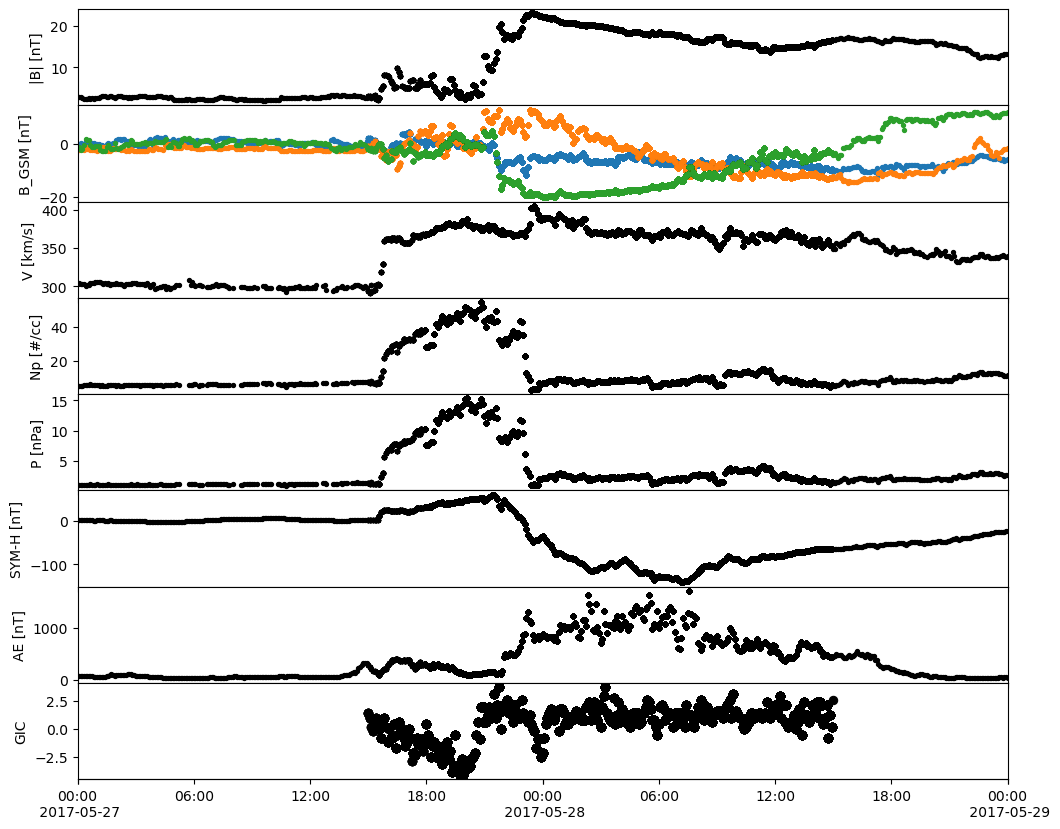

In [56]:
plot_ID = '10119'


fig, axarr = plt.subplots(8, sharex=True)
plt.subplots_adjust(hspace = .001) 

axarr[0].set_xlim([event_start,event_end])

axarr[0].set_ylabel('|B| [nT]')
axarr[0].scatter(df_final['datetimes'], df_final['F'], color='black', s=8)

axarr[1].set_ylabel('B_GSM [nT]')
axarr[1].scatter(df_final['datetimes'], df_final['BX_GSE'], color='tab:blue', s=8)
axarr[1].scatter(df_final['datetimes'], df_final['BY_GSM'], color='tab:orange', s=8)
axarr[1].scatter(df_final['datetimes'], df_final['BZ_GSM'], color='tab:green', s=8)

axarr[2].set_ylabel('V [km/s]')
axarr[2].scatter(df_final['datetimes'], df_final['flow_speed'], color='black', s=8)

axarr[3].set_ylabel('Np [#/cc]')
axarr[3].scatter(df_final['datetimes'], df_final['proton_density'], color='black', s=8)

axarr[4].set_ylabel('P [nPa]')
axarr[4].scatter(df_final['datetimes'], df_final['Pressure'], color='black', s=8)

axarr[5].set_ylabel('SYM-H [nT]')
axarr[5].scatter(df_final['datetimes'], df_final['SYM_H'], color='black', s=8)

axarr[6].set_ylabel('AE [nT]')
axarr[6].scatter(df_final['datetimes'], df_final['AE_INDEX'], color='black', s=8)

axarr[7].set_ylabel('GIC')
axarr[7].scatter(df_final['datetimes'], df_final[plot_ID], color='black', lw=0.8)

axarr[7].xaxis.set_major_locator(mdates.HourLocator([0,6,12,18]))
axarr[7].xaxis.set_major_formatter(mdates.DateFormatter('%H:00'))
axarr[7].tick_params(axis='x', which='major')

xaxis_copy = axarr[7].secondary_xaxis('bottom')
xaxis_copy.xaxis.set_major_locator(mdates.DayLocator(interval=1))
xaxis_copy.xaxis.set_major_formatter(mdates.DateFormatter('%n %Y-%m-%d'))
xaxis_copy.tick_params(axis='x', which='major')

fig.set_size_inches(12,10)
fig.patch.set_facecolor('white')

plt.show()

In [64]:
'/Users/ryanmc/Documents/Conferences/Jack_Eddy_Symposium_2022/data/integrated_data_'+event_list[event_no][3]+'.csv'

'/Users/ryanmc/Documents/Conferences/Jack_Eddy_Symposium_2022/data/integrated_data_event_20170527.csv'

### Save the dataframe

In [68]:
df_final.to_csv('/Users/ryanmc/Documents/Conferences/Jack_Eddy_Symposium_2022/dev/integrated_data/integrated_data_'+event_list[event_no][3]+'.csv')




